# Antarctica Mesh

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
import jaxopt, optax
from tinygp.kernels.stationary import ExpSquared

import pyvista as pv
import jraph

pv.global_theme.trame.server_proxy_enabled = True
pv.start_xvfb(wait=2)

In [5]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
from emmd.utils import grid
from emmd.mmd import ImpCloudMMD, ergodic_metric
from emmd.transforms import Transform, ARD, DeepCK, GATKernel, DeepKernel
from emmd.kernels import RFF
from emmd.train import train_mmd_kernel, \
    train_mmd, train_mmd_kernel_gp, train_mmd_kernel_score
from emmd.gp import gp_pred
from emmd.score import ScoreDensity
from emmd.mesh import point_in_mesh_fn, traj_to_line

In [7]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [8]:
key = jax.random.PRNGKey(0)

## Data

In [9]:
ant = pv.examples.download_antarctica_velocity()
ant_bounds = ant.bounds
ant_bounds = jnp.array(ant_bounds).reshape(3, 2).T
bounds = ant_bounds * 1.25
bounds = bounds[:, :-1]  # make 2d as nonexistent third dim

standard_scale = lambda x: (x - bounds[0]) / (bounds[1] - bounds[0])
inv_scale = lambda x: x * (bounds[1] - bounds[0]) + bounds[0]

In [10]:
ant.point_data['ssavelocity'].shape

(557470, 3)

In [11]:
ant["magnitude"] = jnp.linalg.norm(ant["ssavelocity"], axis=1)
X_grid = grid(bounds, N=100, flatten=False)
X_flat = grid(bounds, N=100)

velocity = jnp.asarray(ant.point_data['ssavelocity'])
magnitude = jnp.linalg.norm(velocity, axis=1)
points = jnp.asarray(ant.points)[:, :-1]
# scale points
points_sc = standard_scale(points)

Sample according to magnitude

In [12]:
n_samples = 5000
sample_inds = jax.random.choice(
    key, jnp.arange(len(points)), shape=(n_samples,), replace=False, p=magnitude / magnitude.sum()
)
samples = points[sample_inds]
sample_mag = magnitude[sample_inds]
samples_sc = points_sc[sample_inds]
sample_plot = jnp.concat([samples, jnp.zeros((len(samples), 1))], axis=-1)

uni_sample_inds = jax.random.choice(key, jnp.arange(len(points)), shape=(n_samples,), replace=False)
uni_samples = points[uni_sample_inds]
uni_mag = magnitude[uni_sample_inds]
uni_sc = points_sc[uni_sample_inds]
uni_plot = jnp.concat([uni_samples, jnp.zeros((len(uni_samples), 1))], axis=-1)

In [51]:
n_traj = 500
# traj_init = jnp.linspace(jnp.zeros(2), jnp.ones(2), num=n_traj, endpoint=True)
traj_init = jax.random.choice(key, samples_sc, shape=(n_traj,), replace=False)
traj_init = traj_init[traj_init[:, 0].argsort()]

jnp.sin(360)

Array(0.95891572, dtype=float64, weak_type=True)

In [52]:
def circle_init(midpt, radius):
    theta = jnp.linspace(0, 2 * jnp.pi, num=n_traj)
    x = midpt[0] + radius * jnp.cos(theta)
    y = midpt[1] + radius * jnp.sin(theta)
    return jnp.stack([x, y], axis=-1)
traj_init = circle_init(jnp.array([0.5, 0.5]), 0.5)

In [14]:
# auxilary loss functions
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

### Initial Metric and Plots

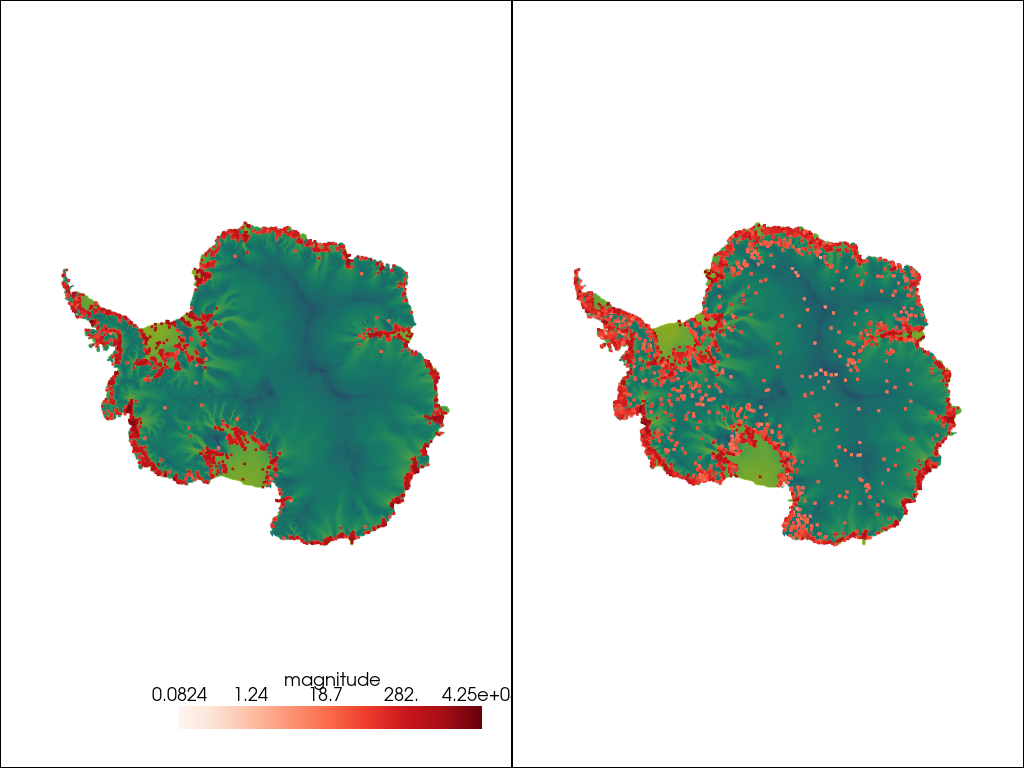

In [15]:
sample_pts = pv.PointSet(sample_plot)
sample_pts['magnitude'] = sample_mag

uni_pts = pv.PointSet(uni_plot)
uni_pts['magnitude'] = uni_mag

pl = pv.Plotter(notebook=True, shape=(1,2))
pl.subplot(0, 0)
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
pl.add_points(sample_pts, scalars="magnitude", cmap="Reds", point_size=3, log_scale=True)
pl.view_xy()

pl.subplot(0,1)
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
pl.add_points(uni_pts, scalars="magnitude", cmap="Reds", point_size=3, log_scale=True)
pl.show(cpos="xy", jupyter_backend='pythreejs')

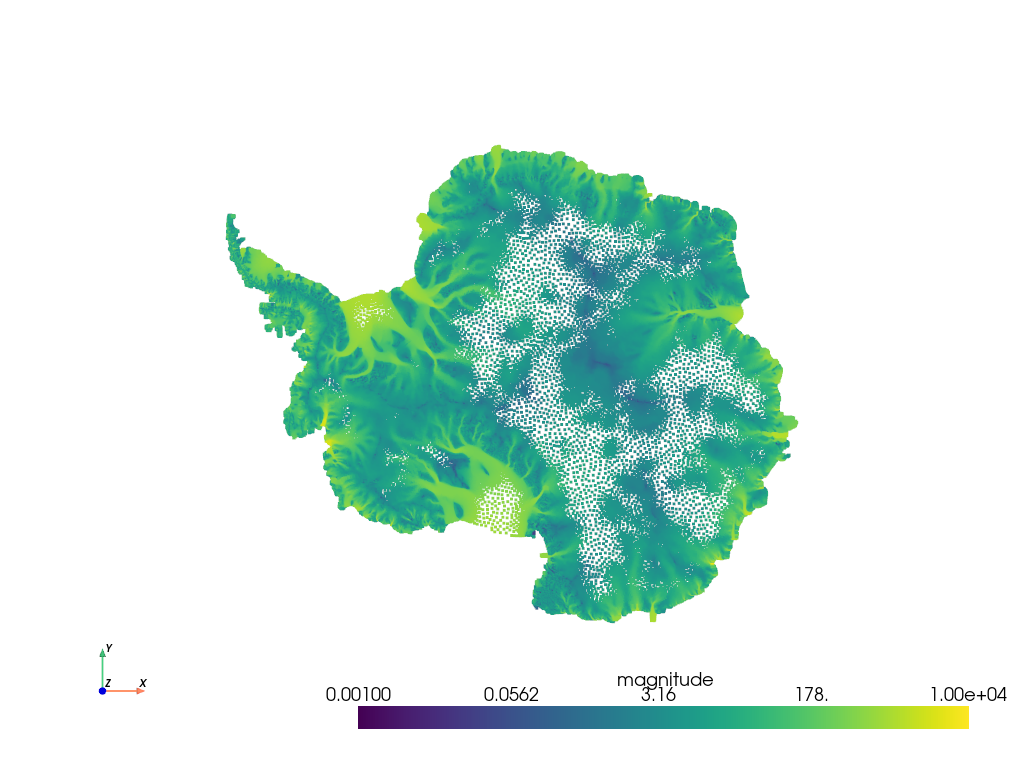

In [16]:
pv.PointSet(ant).plot(
    scalars="magnitude", clim=[1e-3, 1e4], cmap="viridis", point_size=3,
    cpos='xy', log_scale=True, jupyter_backend='pythreejs'
)

<Axes: ylabel='Count'>

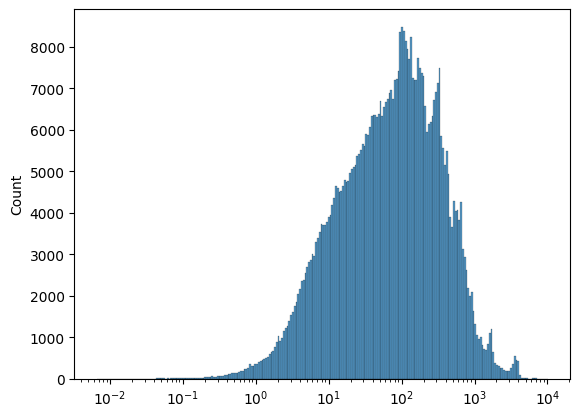

In [18]:
sns.histplot(magnitude, log_scale=True)

## Model Definitions

In [15]:
def train_rbf_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), ExpSquared())
    k_rff_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    mmd_init = ImpCloudMMD(k_init, traj_init)
    mmd_rff_init = ImpCloudMMD(k_rff_init, traj_init)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, to_train=lambda t: [t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_rff_init, samples, prob_samples, to_train=lambda t: [t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [t.k.transform.scale, t.z]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [16]:
def train_rff_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    mmd_init = ImpCloudMMD(k_init, traj_init)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.kernel.w, t.k.transform.scale, t.z, t.q_params, t.alpha
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [17]:
def train_deep_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    n_hidden = kwargs.get("n_layers", 4)
    d_hidden = kwargs.get("d_hidden", 64)
    d_out = kwargs.get("out_dim", 8)
    k_init = DeepCK(key, in_dim=d, out_dim=d_out, d_hidden=d_hidden, n_layers=n_hidden)
    
    mmd_init = ImpCloudMMD(k_init, traj_init)

    # power training
    training_param_fn = lambda t: [
        t.k.dk, t.k.ck.transform.scale#, t.k.epsilon
    ]

    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=training_param_fn,
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=training_param_fn,
        lowrank=False, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.dk, t.k.ck.transform.scale, t.k.epsilon, t.z, #t.L# t.q_params, t.L #t.alpha
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    # return mmd_init, mmd_power, mmd_score
    return mmd_init, mmd_power, mmd_gp, mmd_score


In [18]:
def train_graph_kernels(
    key, traj_graph, samples_graph, score_params,
    **kwargs
):
    traj_init = traj_graph.nodes
    samples = samples_graph.nodes
    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.pop("R", 100)
    n_layers = kwargs.pop("n_layers", 3)
    d_hidden = kwargs.pop("d_hidden", 64)
    out_dim = kwargs.pop("out_dim", 10)
    dropout = kwargs.pop("dropout", 0.3)
    n_heads = kwargs.pop("n_heads", 4)
    epsilon = kwargs.pop("epsilon", 0.2)
    
    k_init = GATKernel(
        key, d, out_dim, d_hidden=d_hidden, n_layers=n_layers, 
        dropout=dropout, n_heads=n_heads, ls=ls_init, epsilon=epsilon
    )
    mmd_init = ImpCloudMMD(k_init, traj_init)

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.gat, t.k.ck.transform.scale, t.k.epsilon, t.z #, t.q_params, t.alpha
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_score


In [19]:
def train_trajectories(
        key, models, samples, bounds, aux_loss, 
        solver_params={}, use_adam=False, **kwargs
    ):

    if use_adam:
        def training_fn(model):
            return train_mmd(
                key, model, samples, aux_loss=aux_loss, optimizer="optax",
                **solver_params
            )

    else:
        def training_fn(model):
            return train_mmd(
                key, model, samples, bounds, aux_loss=aux_loss, 
                opt_params=solver_params
            )

    res = []
    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model_trained, _ = training_fn(model)
        res.append(model_trained)

    return res


## Run Models

In [20]:
epochs_k = 2000
epochs_mmd = 1000
lr = 1e-3

### RBF

In [25]:
rbf_power_params = {
    'epochs': epochs_k, 'lr': lr, 'verbose': False
}
rbf_gp_params = {
    "epochs": epochs_k, 'diag': 1e-3, 'lr': lr, 'verbose': False
}
rbf_score_params = {
    'lr': 1e-2, 'q': 'normal',
    'epochs': epochs_k, 'verbose': True
}

Train kernels:

In [28]:
rbf_init, rbf_power, rbf_gp, rbf_score = train_rbf_kernels(
    key, traj_init, samples_sc, sample_mag, bounds, rbf_power_params, rbf_gp_params, rbf_score_params
)

Training power
Training gp
Training score
epoch 0,loss: -13.09305575989372
epoch 50,loss: -16.131262229994423
epoch 100,loss: -20.396502762284772
epoch 150,loss: -30.336783776381044
epoch 200,loss: -117.62197216267623
epoch 250,loss: -750.097557061008
epoch 300,loss: -540.7754791088297
epoch 350,loss: -511.0651173840566
epoch 400,loss: -408.27493746212775
epoch 450,loss: -310.14541017056445
epoch 500,loss: -321.8053411032889
epoch 550,loss: -302.86967083471285
epoch 600,loss: -303.43752771759455
epoch 650,loss: -302.157814111278
epoch 700,loss: -310.4345224436762
epoch 750,loss: -309.896954329968
epoch 800,loss: -279.13962601787347
epoch 850,loss: -196.3329777233412
epoch 900,loss: -169.59462350672578
epoch 950,loss: -156.8045128920103
epoch 1000,loss: -147.76911050285312
epoch 1050,loss: -105.06522772984742
epoch 1100,loss: -121.59809923022046
epoch 1150,loss: -93.23350757495362
epoch 1200,loss: -73.33927801445833
epoch 1250,loss: -78.53974424622699
epoch 1300,loss: -93.50398810945214

In [29]:
rbf_models = (rbf_init, rbf_power, rbf_gp, rbf_score)

for model in rbf_models:
    print(f"Scale: {model.k.transform._scale}")

Scale: [0.23727878 0.19303597]
Scale: [1.10237253 0.62452449]
Scale: [0.05387521 0.04365195]
Scale: [0.00015524 0.01825069]


Train trajectories with MMD:

In [30]:
rbf_traj_init, rbf_power_traj, rbf_gp_traj, rbf_score_traj = train_trajectories(
        key, rbf_models, samples_sc, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds,
        # solver_params={'tol': 1e-4, 'maxiter': 1000}, use_adam=False, 
        solver_params={'epochs': 3000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rbf_trajectories = (
    inv_scale(rbf_traj_init.w), inv_scale(rbf_power_traj.w), 
    inv_scale(rbf_gp_traj.w), inv_scale(rbf_score_traj.w)
)

Training model 1
epoch 0, mmd loss: 0.0014328363298084512, aux loss: 0.19785773064983594
epoch 100, mmd loss: 0.010946941330522264, aux loss: 0.047858237645123744
epoch 200, mmd loss: 0.0011440466547058548, aux loss: 0.01029461718685573
epoch 300, mmd loss: 0.000247145718139441, aux loss: 0.003232153061697291
epoch 400, mmd loss: 0.0001375920462310387, aux loss: 0.0017071307431592159
epoch 500, mmd loss: 6.780784469512247e-05, aux loss: 0.001082843489309462
epoch 600, mmd loss: 4.63008180941471e-05, aux loss: 0.0008012905796646902
epoch 700, mmd loss: 4.399055305293054e-05, aux loss: 0.0006685759168170324
epoch 800, mmd loss: 3.999166369650364e-05, aux loss: 0.0005772998929011135
epoch 900, mmd loss: 3.7892081038493064e-05, aux loss: 0.0004912805665060125
epoch 1000, mmd loss: 3.6903394178111615e-05, aux loss: 0.0004167486970475835
epoch 1100, mmd loss: 2.4745888307864394e-05, aux loss: 0.00034721513648972263
epoch 1200, mmd loss: 1.4844275253778072e-05, aux loss: 0.0002997955170812195

2024-05-22 01:25:46.369459: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %dot.41 = f64[5000,5000]{1,0} dot(f64[5000,200]{1,0} %constant.129, f64[5000,200]{1,0} %constant.141), lhs_contracting_dims={1}, rhs_contracting_dims={1}, metadata={op_name="jit(opt_step)/jit(main)/jvp(vmap(vmap(jit(evaluate))))/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=float64]" source_file="/home/houston/devel/ergodic_mmd/emmd/kernels.py" source_line=65}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-05-22 01:25:52.956120: E external/xla/xla/service/

epoch 0, mmd loss: 0.001314109455995055, aux loss: 0.19785773064983594
epoch 100, mmd loss: 0.015332362817448972, aux loss: 0.0423966092034957
epoch 200, mmd loss: 0.005117186749346149, aux loss: 0.011962725521283532
epoch 300, mmd loss: 0.001321434748422931, aux loss: 0.006070954289379721
epoch 400, mmd loss: 0.0007569209442541691, aux loss: 0.00409574708826609
epoch 500, mmd loss: 0.0006085096916587096, aux loss: 0.003436795990856544
epoch 600, mmd loss: 0.000529393608890219, aux loss: 0.0030179252175450972
epoch 700, mmd loss: 0.00048336017011463284, aux loss: 0.0027747275116747094
epoch 800, mmd loss: 0.00046345539497945343, aux loss: 0.002707431860415704
epoch 900, mmd loss: 0.0004549372469243723, aux loss: 0.002649022561567557
epoch 1000, mmd loss: 0.0004434623378195973, aux loss: 0.0024181320258207556
epoch 1100, mmd loss: 0.00034833647449970806, aux loss: 0.0020804302281435196
epoch 1200, mmd loss: 0.0003029828187527809, aux loss: 0.0018817059810797324
epoch 1300, mmd loss: 0.0

### RFF

In [33]:
rff_power_params = {
    'epochs': 3000, 'lr': 1e-3, 'verbose': False
}
rff_gp_params = {
    "epochs": 3000, 'diag': 1e-3, 'lr': 1e-3, 'verbose': True
}
rff_score_params = {
    'lr': 1e-2, 'q': 'normal',
    'epochs': 3000, 'verbose': True
}

In [34]:
rff_init, rff_power, rff_gp, rff_score = train_rff_kernels(
    key, traj_init, samples_sc, sample_mag, bounds, rff_power_params, rff_gp_params, rff_score_params
)

Training power
epoch 0,loss: -0.05968806871960424
epoch 50,loss: -0.0270353644055584
epoch 100,loss: -0.002085848482334175
epoch 150,loss: 0.018486806304353138
epoch 200,loss: 0.035755658048645604
epoch 250,loss: 0.05032773106640287
epoch 300,loss: 0.06282632110191048
epoch 350,loss: 0.0736680703404727
epoch 400,loss: 0.08314343353064363
epoch 450,loss: 0.09148009677057692
epoch 500,loss: 0.09884845074653503
epoch 550,loss: 0.10536977636568344
epoch 600,loss: 0.11115340321836485
epoch 650,loss: 0.11633166142508718
epoch 700,loss: 0.12106937171778016
epoch 750,loss: 0.12555253929776966
epoch 800,loss: 0.1299826122479069
epoch 850,loss: 0.13457788409641377
epoch 900,loss: 0.13935879074855054
epoch 950,loss: 0.14406124426137232
epoch 1000,loss: 0.14875634895073483
epoch 1050,loss: 0.15348992282098775
epoch 1100,loss: 0.15777217134306387
epoch 1150,loss: 0.16143872453550584
epoch 1200,loss: 0.16450877590001453
epoch 1250,loss: 0.16699927954139113
epoch 1300,loss: 0.1689774343271105
epoch 1

In [37]:
rff_models = (rff_init, rff_power, rff_gp, rff_score)

In [45]:
rff_traj_init, rff_power_traj, rff_gp_traj, rff_score_traj = train_trajectories(
        key, rff_models, samples_sc, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-4, 'maxiter': 1000}, use_adam=False, 
        # solver_params={'epochs': 5000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rff_trajectories = (
    inv_scale(rff_traj_init.w), inv_scale(rff_power_traj.w), 
    inv_scale(rff_gp_traj.w), inv_scale(rff_score_traj.w)
)

Training model 1
{'tol': 1e-05, 'maxiter': 1000}
Training model 2
{'tol': 1e-05, 'maxiter': 1000}


2024-05-22 01:37:23.464641: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 8s:

  %dot.26 = f64[5000,5000]{1,0} dot(f64[5000,200]{1,0} %constant.78, f64[5000,200]{1,0} %constant.90), lhs_contracting_dims={1}, rhs_contracting_dims={1}, metadata={op_name="jit(loss_fn)/jit(main)/vmap(vmap(jit(evaluate)))/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=float64]" source_file="/home/houston/devel/ergodic_mmd/emmd/kernels.py" source_line=65}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-05-22 01:37:23.481873: E external/xla/xla/service/slow_ope

Training model 3
{'tol': 1e-05, 'maxiter': 1000}
Training model 4
{'tol': 1e-05, 'maxiter': 1000}


### Deep Kernel

In [55]:
deep_power_params = {
    'epochs': 1, 'lr': 1e-3, 'verbose': False
}
deep_gp_params = {
    "epochs": 1, 'diag': 1e-4, 'lr': 1e-3, 'verbose': True
}
deep_score_params = {
    'lr': 1e-2, 'q': 'uniform', 'q_params': standard_scale(bounds),
    'epochs': 1000, 'verbose': True
}

In [56]:
deep_init, deep_power, deep_gp, deep_score = train_deep_kernels(
    key, traj_init, samples_sc, sample_mag, bounds, deep_power_params, deep_gp_params, deep_score_params
)
deep_models = (deep_init, deep_power, deep_gp, deep_score)

Training power
Training gp
epoch 0,loss: 18756006996603.855
Training score
epoch 0,loss: -0.9318103138004042
epoch 50,loss: -1.1489758174699414
epoch 100,loss: -1.8870312040899375
epoch 150,loss: -4.132885821328969
epoch 200,loss: -10.081025994046131
epoch 250,loss: -18.89669778716241
epoch 300,loss: -2.6805306747903423
epoch 350,loss: -7.276248655851376
epoch 400,loss: -44.489388724398424
epoch 450,loss: -57.172559347662926
epoch 500,loss: -64.26254889355745
epoch 550,loss: -64.6192922417343
epoch 600,loss: -62.32183668459343
epoch 650,loss: -63.227749937108065
epoch 700,loss: -63.93777628365496
epoch 750,loss: -64.52523641471123
epoch 800,loss: -64.96774992362134
epoch 850,loss: -65.25386859138129
epoch 900,loss: -65.40935828788051
epoch 950,loss: -65.47138366602529


In [57]:
jnp.abs(gp_pred(deep_score.k, samples_sc, sample_mag, uni_sc)[0] - uni_mag).mean()

Array(452.28064685, dtype=float64)

In [61]:
deep_traj_trained = train_trajectories(
        # key, deep_models, samples_sc, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds
        key, [deep_score], samples_sc, aux_loss=traj_loss_fn, bounds=None, #bounds=bounds
        # solver_params={'tol': 1e-5, 'maxiter': 20_000}, use_adam=False, 
        solver_params={'epochs': 2000, 'lr': 1e-2, 'verbose': True}, use_adam=True, opt=optax.sgd(1e-3)
)
deep_trajectories = [inv_scale(d.w) for d in deep_traj_trained]

Training model 1
epoch 0, mmd loss: 0.06974196624085993, aux loss: 3.9636282592891577e-05
epoch 100, mmd loss: 0.01098095249705433, aux loss: 0.000627666981181266
epoch 200, mmd loss: 0.00024748704621124773, aux loss: 0.0002408935641247282
epoch 300, mmd loss: 8.090688539430511e-05, aux loss: 0.00012206123257640061
epoch 400, mmd loss: 6.362491997491394e-05, aux loss: 0.00010333541693725508
epoch 500, mmd loss: 5.5414021724931026e-05, aux loss: 9.564212087983665e-05
epoch 600, mmd loss: 4.692636072611832e-05, aux loss: 8.572572822009333e-05
epoch 700, mmd loss: 4.1801360509130525e-05, aux loss: 8.142901356737351e-05
epoch 800, mmd loss: 3.624589985840032e-05, aux loss: 8.001320681444946e-05
epoch 900, mmd loss: 3.091421456313803e-05, aux loss: 7.815088614220444e-05
epoch 1000, mmd loss: 2.4375629887329886e-05, aux loss: 7.359042169417458e-05
epoch 1100, mmd loss: 2.1785591445389052e-05, aux loss: 7.267470648371622e-05
epoch 1200, mmd loss: 2.065359031933056e-05, aux loss: 7.18853051218

## Visualize

### RBF

In [31]:
traj_line1 = jnp.concatenate([rbf_trajectories[0], jnp.zeros((len(rbf_trajectories[0]), 1))], axis=-1)
line1 = traj_to_line(traj_line1, color=True)
traj_line2 = jnp.concatenate([rbf_trajectories[1], jnp.zeros((len(rbf_trajectories[1]), 1))], axis=-1)
line2 = traj_to_line(traj_line2, color=True)
traj_line3 = jnp.concatenate([rbf_trajectories[2], jnp.zeros((len(rbf_trajectories[2]), 1))], axis=-1)
line3 = traj_to_line(traj_line3, color=True)
traj_line4 = jnp.concatenate([rbf_trajectories[3], jnp.zeros((len(rbf_trajectories[3]), 1))], axis=-1)
line4 = traj_to_line(traj_line4, color=True)

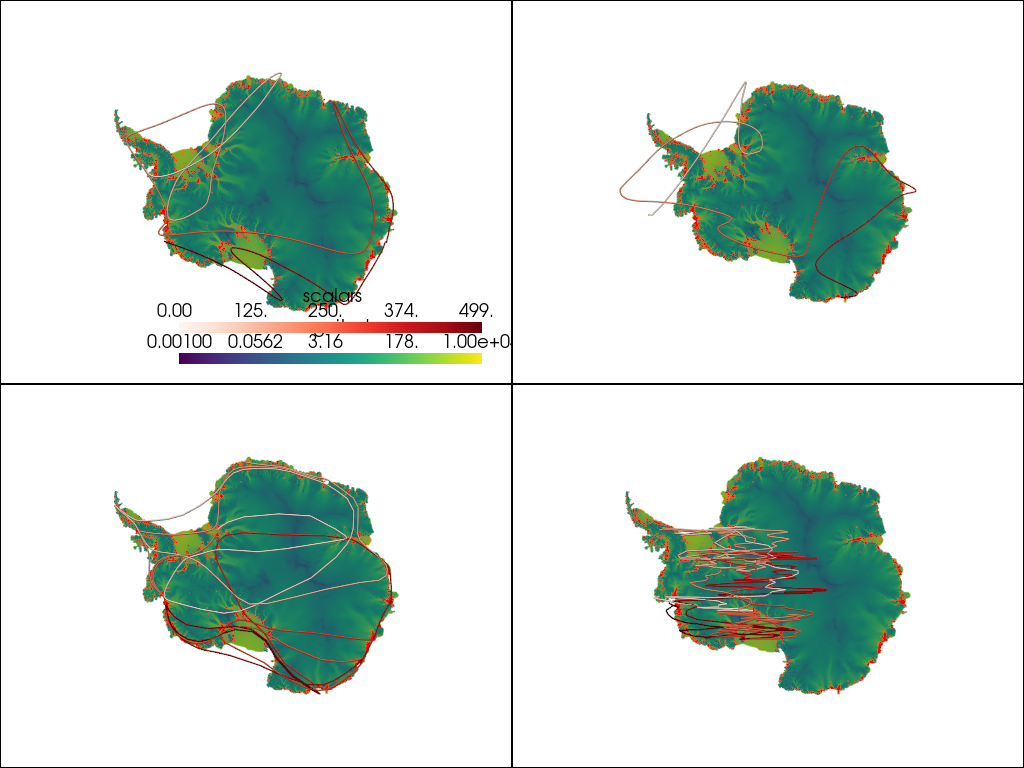

In [32]:
radius = 15_000
pl = pv.Plotter(notebook=True, shape=(2, 2))
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)

pl.subplot(0, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube1 = line1.tube(radius=radius)
pl.add_mesh(tube1, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(0, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube2 = line2.tube(radius=radius)
pl.add_mesh(tube2, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(1, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube3 = line3.tube(radius=radius)
pl.add_mesh(tube3, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(1, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube4 = line4.tube(radius=radius)
pl.add_mesh(tube4, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.show(jupyter_backend='pythreejs', cpos='xy')

### RFF

In [48]:
traj_line1 = jnp.concatenate([rff_trajectories[0], jnp.zeros((len(rff_trajectories[0]), 1))], axis=-1)
line1 = traj_to_line(traj_line1, color=True)
traj_line2 = jnp.concatenate([rff_trajectories[1], jnp.zeros((len(rff_trajectories[1]), 1))], axis=-1)
line2 = traj_to_line(traj_line2, color=True)
traj_line3 = jnp.concatenate([rff_trajectories[2], jnp.zeros((len(rff_trajectories[2]), 1))], axis=-1)
line3 = traj_to_line(traj_line3, color=True)
traj_line4 = jnp.concatenate([rff_trajectories[3], jnp.zeros((len(rff_trajectories[3]), 1))], axis=-1)
line4 = traj_to_line(traj_line4, color=True)

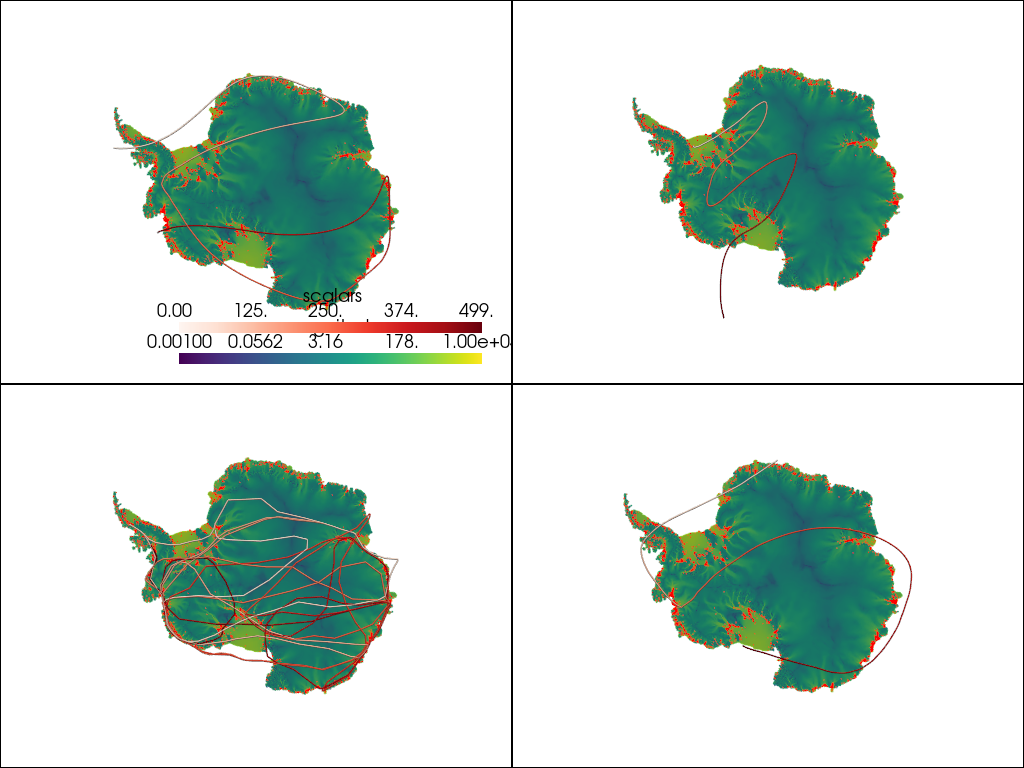

In [49]:
radius = 15_000
pl = pv.Plotter(notebook=True, shape=(2, 2))
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)

pl.subplot(0, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube1 = line1.tube(radius=radius)
pl.add_mesh(tube1, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(0, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube2 = line2.tube(radius=radius)
pl.add_mesh(tube2, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(1, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube3 = line3.tube(radius=radius)
pl.add_mesh(tube3, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(1, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube4 = line4.tube(radius=radius)
pl.add_mesh(tube4, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.show(jupyter_backend='pythreejs', cpos='xy')

### Deep Kernels

In [62]:
traj_line1 = jnp.concatenate([deep_trajectories[0], jnp.zeros((len(deep_trajectories[0]), 1))], axis=-1)
line1 = traj_to_line(traj_line1, color=True)
# traj_line2 = jnp.concatenate([deep_trajectories[1], jnp.zeros((len(deep_trajectories[1]), 1))], axis=-1)
# line2 = traj_to_line(traj_line2, color=True)
# traj_line3 = jnp.concatenate([deep_trajectories[2], jnp.zeros((len(deep_trajectories[2]), 1))], axis=-1)
# line3 = traj_to_line(traj_line3, color=True)
# traj_line4 = jnp.concatenate([deep_trajectories[3], jnp.zeros((len(deep_trajectories[3]), 1))], axis=-1)
# line4 = traj_to_line(traj_line4, color=True)

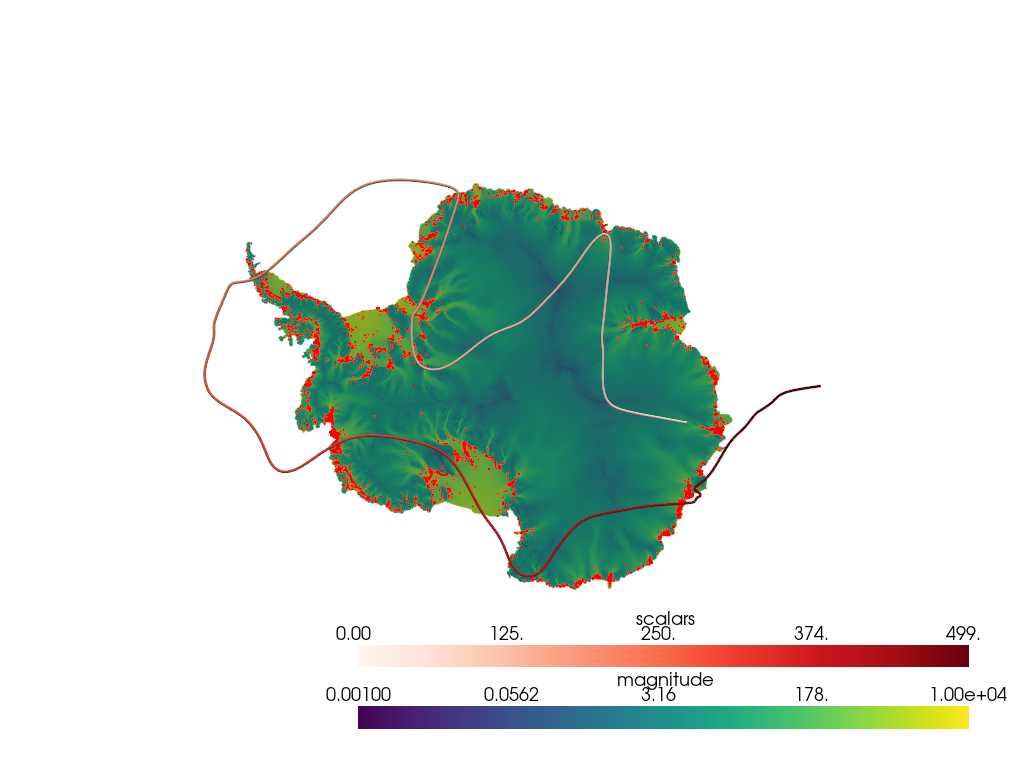

In [63]:
pl = pv.Plotter(notebook=True)
radius = 15_000
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)
# pl.subplot(0, 2)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube1 = line1.tube(radius=radius)
pl.add_mesh(tube1, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=2, log_scale=True)
pl.show(jupyter_backend='pythreejs', cpos='xy')

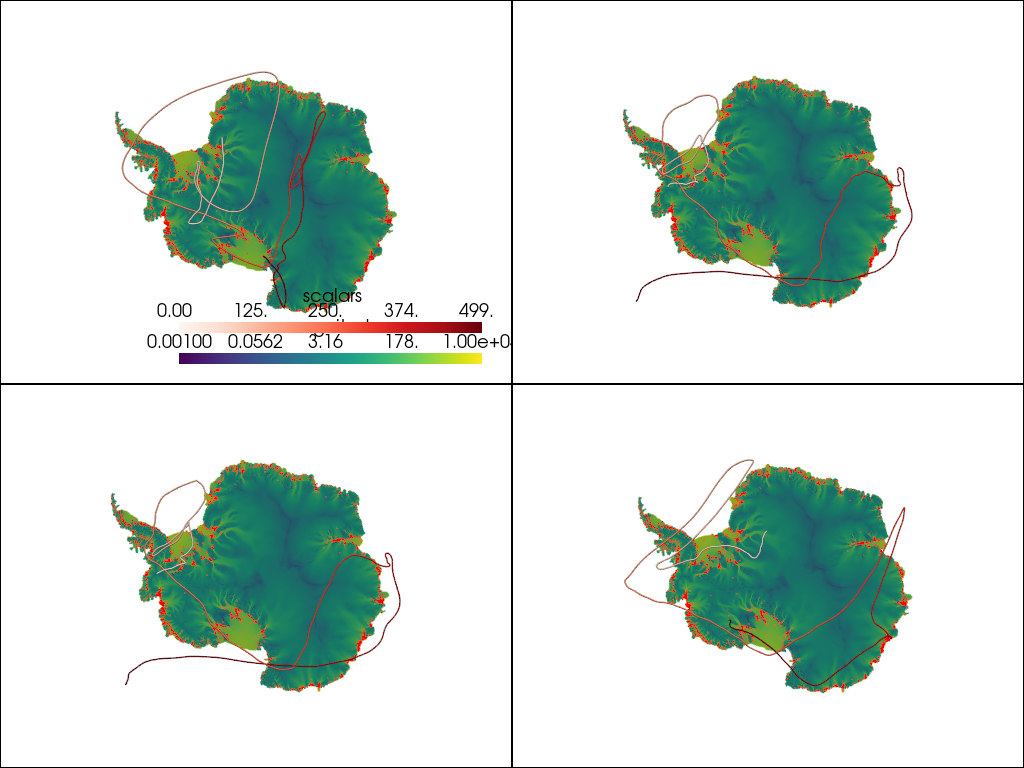

In [41]:
radius = 15_000
pl = pv.Plotter(notebook=True, shape=(2, 2))
# pl = pv.Plotter(notebook=True, shape=(1, 3))
vel_dargs = dict(scalars="magnitude", clim=[1e-3, 1e4], log_scale=True)

pl.subplot(0, 0)
# pl.subplot(0, 0)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube1 = line1.tube(radius=radius)
pl.add_mesh(tube1, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(0, 1)
# pl.subplot(0, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube2 = line2.tube(radius=radius)
pl.add_mesh(tube2, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(1, 0)
# pl.subplot(0, 2)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube3 = line3.tube(radius=radius)
pl.add_mesh(tube3, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.subplot(1, 1)
pl.add_mesh(ant, show_edges=False, **vel_dargs)
tube4 = line4.tube(radius=radius)
pl.add_mesh(tube4, smooth_shading=True, cmap="Reds")
pl.add_points(pv.PointSet(sample_plot), color="red", point_size=1, log_scale=True)
pl.view_xy()

pl.show(jupyter_backend='pythreejs', cpos='xy')

## Metrics

In [105]:
def mse(x, y):
    return jnp.mean((x-y)**2)

### RBF

In [24]:
rbf_init_erg = ergodic_metric(rbf_traj_init.w, bounds, n_modes=20, n_per_dim=60)
rbf_power_erg = ergodic_metric(rbf_power_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_gp_erg = ergodic_metric(rbf_gp_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_score_erg = ergodic_metric(rbf_score_traj.w, bounds, n_modes=20, n_per_dim=60)

NameError: name 'rbf_traj_init' is not defined

In [123]:
# errors
mse(rbf_init_erg, prob_X_flat), mse(rbf_power_erg, prob_X_flat), \
    mse(rbf_gp_erg, prob_X_flat), mse(rbf_score_erg, prob_X_flat)

(Array(28.25934436, dtype=float64),
 Array(29.97701283, dtype=float64),
 Array(192.97166348, dtype=float64),
 Array(48.23838574, dtype=float64))